In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls "/content/gdrive/My Drive/"
%cd "/content/gdrive/My Drive/Datasets"
!unzip "/content/gdrive/My Drive/Datasets/free-spoken-digit-dataset-master.zip"

'Colab Notebooks'   Datasets
/content/gdrive/My Drive/Datasets
Archive:  /content/gdrive/My Drive/Datasets/free-spoken-digit-dataset-master.zip
84091eedc06bf49fb77d71c92311f9cab4f4695c
replace free-spoken-digit-dataset-master/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import os
import librosa
import numpy as np
import librosa.display
from pathlib import Path
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
path="/content/gdrive/My Drive/Datasets/free-spoken-digit-dataset-master/recordings"
files=librosa.util.find_files(path)

In [0]:
mfccs=[]
labels=[]
max_pad_len=36

In [0]:
for f in files:
    wave,sr=librosa.load(f,sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=8000)
    pad_width=max_pad_len-mfcc.shape[1]
    mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    mfccs.append(mfcc)
    label=int(Path(f).stem[0])
    labels.append(label)

In [0]:
mfccs=np.asarray(mfccs)
mfccs.shape
mfccs=np.reshape(mfccs,(2000,1,20,36))
print(mfccs.shape)

(2000, 1, 20, 36)


In [0]:
data_tensors=torch.stack([torch.Tensor(i) for i in mfccs])
label_tensors=torch.Tensor(labels)

In [0]:
dataset=torch.utils.data.TensorDataset(data_tensors,label_tensors)

In [0]:
testsplit=int(0.2*len(dataset))
trainsplit=int(len(dataset)-testsplit)

In [0]:
trainset,testset=torch.utils.data.random_split(dataset,[trainsplit,testsplit])

In [0]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

In [0]:
dataiter=iter(trainloader)
i,l=dataiter.next()
print(i.shape)
print(l.shape)

torch.Size([64, 1, 20, 36])
torch.Size([64])


In [0]:
# layers=[]
# layers.append(nn.Conv2d(3,32,2))
# layers.append(nn.ReLU())
# layers.append(nn.BatchNorm2d(32))
# layers.append(nn.Conv2d(32,48,2))
# layers.append(nn.ReLU())
# layers.append(nn.BatchNorm2d(48))
# layers.append(nn.Conv2d(48,120,2))
# layers.append(nn.ReLU())
# layers.append(nn.BatchNorm2d(120))
# layers.append(nn.MaxPool2d(2))
# layers.append(nn.Dropout2d(0.25))
vgg16=models.vgg16()
net=vgg16
net.classifier[6] = nn.Linear(4096,10)
net.features[0]=nn.Conv2d(1,64,3,1,1)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
batch_size=64

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

In [0]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
def train_net(net,epochs,X):
    train_loss_values=[]
    for epoch in range(epochs):
        running_loss=0.0
        mini_loss=0.0
        for i,data in enumerate(X,0):
            inputs,labels=data
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            outputs=net(inputs)
            loss=criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            mini_loss+=loss.item()*inputs.size(0)
            running_loss+=loss.item()*inputs.size(0)
            if i%5==4:  
                print('[%d,%5d]loss:%.5f'%(epoch+1,i+1,mini_loss/5))
                mini_loss = 0.0
        train_loss_values.append(running_loss/len(X)*batch_size)
    plt.plot(train_loss_values)
            
        
        

In [0]:
#train_net(net,35,trainloader)

In [0]:
#testloader=torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

In [0]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         images=images.to(device)
#         labels=labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct+=(predicted==labels.long()).sum().item()

In [0]:
#print(100*correct/total)

[1,    5]loss:259.85219
[1,   10]loss:147.43767
[1,   15]loss:145.95849
[1,   20]loss:143.64437
[1,   25]loss:136.54910
[1,   30]loss:128.46080
[2,    5]loss:116.41066
[2,   10]loss:101.40779
[2,   15]loss:98.23057
[2,   20]loss:111.19117
[2,   25]loss:102.62616
[2,   30]loss:81.77746
[3,    5]loss:86.52476
[3,   10]loss:79.15351
[3,   15]loss:80.61391
[3,   20]loss:74.97087
[3,   25]loss:86.58062
[3,   30]loss:72.04568
[4,    5]loss:69.54314
[4,   10]loss:57.89924
[4,   15]loss:53.38099
[4,   20]loss:65.70449
[4,   25]loss:61.25719
[4,   30]loss:57.84709
[5,    5]loss:41.33993
[5,   10]loss:34.87209
[5,   15]loss:33.49712
[5,   20]loss:40.36749
[5,   25]loss:37.31008
[5,   30]loss:33.10866
[6,    5]loss:33.62871
[6,   10]loss:21.39186
[6,   15]loss:27.17497
[6,   20]loss:26.25199
[6,   25]loss:18.77100
[6,   30]loss:15.53112
[7,    5]loss:22.11054
[7,   10]loss:27.53975
[7,   15]loss:30.85173
[7,   20]loss:17.22151
[7,   25]loss:16.09948
[7,   30]loss:14.00025
[8,    5]loss:19.16331
[

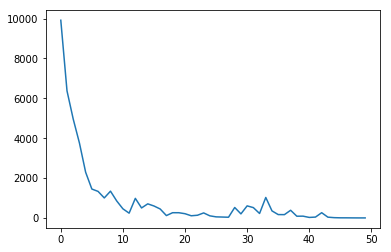

In [0]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)
train_net(net,50,dataloader)

In [0]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)
predictions=[]
for _,data in enumerate(dataloader):
  inputs,labels=data
  inputs=inputs.to(device)
  optimizer.zero_grad()
  output=net(inputs)
  predictions.append(output)

In [0]:
predictions=np.asarray(predictions)
for i in range(len(predictions)):
  predictions[i]=predictions[i].detach().cpu().numpy()
  predictions[i]=predictions[i].flatten()

In [0]:
predictions=predictions.tolist()
predictions

[array([ -3.7093372,  -9.082535 , -13.913568 , -16.87523  ,  -4.0313473,
        -20.392166 ,  -2.7209167,  42.682938 , -21.167896 ,   0.6666118],
       dtype=float32),
 array([  1.4162736 ,  -5.5356627 ,  -6.8513217 ,  -8.9372425 ,
         -2.8586957 , -12.636421  ,  -0.13309497,  22.963037  ,
         -9.40963   ,   0.520693  ], dtype=float32),
 array([-13.791489  , -23.521223  ,  -0.27383494,   4.578071  ,
        -14.561546  , -28.643831  ,  31.03153   ,   1.2048059 ,
          8.92773   , -21.026827  ], dtype=float32),
 array([-33.081337 , -30.28348  ,  -0.955886 ,  48.061428 , -19.893389 ,
        -35.468025 ,   5.645075 ,   0.9895986,   1.0199918, -27.531525 ],
       dtype=float32),
 array([-17.702991 ,   5.3907304, -16.502634 ,  -4.142664 ,  -5.3103905,
          3.832795 ,  -6.8323965,   5.4973917, -11.661378 ,  24.381975 ],
       dtype=float32),
 array([-26.29723  ,  10.053082 , -25.614346 , -12.122494 ,  -7.2034206,
         11.50769  , -11.509943 ,   8.192412 , -19.6198

In [0]:
from sklearn.manifold import TSNE

In [0]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results=tsne.fit_transform(predictions)

In [0]:
tsne_pca_results.shape

(2000, 2)

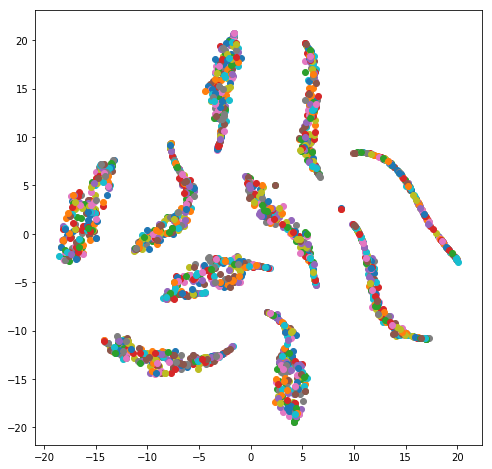

In [0]:
x=[]
y=[]
for value in tsne_pca_results:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(8,8))
for i in range(len(x)):
    plt.scatter(x[i],y[i])